Прежде чем записать код, необходимо разобраться в решаемой задаче и доступных данных. В этом проекте пользуясь командами и модулями Ipython, работаю с данными об измерениях значений относительной минеральной плотности позвоночника подростков, живущих в Северной Америке (в дальнейшем вместо этого длинного значения буду коротко использовать spnbmd, что и соответствует названию датасета). Эти данные я взяла из сайта https://web.stanford.edu/~hastie/ElemStatLearn/data 

Основня цель задачи: на основе имеющихся данных анализировать и построить модель, которая будет наилучшим образом прогнозировать изменение spnbmd в зависимости от различных факторов.

Данные уже включают в себя присвоенные значения spnbmd, поэтому задача представляет собой машинное обучение с управляемой регрессией:
Управляемая (Supervised): известны признаки и цель, и основная задача — обучить модель, которая сможет сопоставить первое со вторым.
Модель должна быть:

точная  —  чтобы могла прогнозировать значение spnbmd близкое к истинному; 
интерпретируемая  —  чтобы было возможно понять её прогнозы.
Для для ознакомления загрузим фото подростков. Для этого использую numpy и matplotlib.pylab.

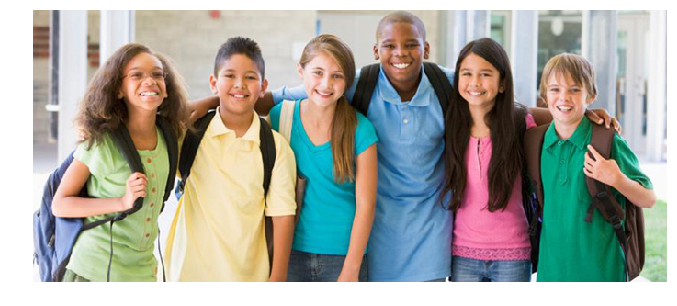

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

im = plt.imread("C:\\Users\\HP\\Desktop\\подростки.png")

def plti(img, h=1, **kwargs):
    """
    Helper function to plot an image.
    """
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w*2000,h*5))
    plt.imshow(im, interpolation="nearest", **kwargs)
    plt.axis('off')
plti(im)

In [2]:
# Для ознакомления с данными использую запрос, а затем загружаю данные 
import requests
import pandas as pd # для работы с матрицами

r = requests.get("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/bone.info.txt")

# Загружаю данные
names = ['idnum', 'ethnic', 'age', 'sex', 'spnbmd']
spnbmd = pd.read_csv('C:\\Users\\HP\\Desktop\\ML\\spnbmd.csv')
spnbmd.head()

,idnum,ethnic,age,sex,spnbmd
0,1,White,11.2,mal,0.719
1,1,White,12.2,mal,0.732
2,1,White,13.2,mal,0.776
3,1,White,14.3,mal,0.781
4,2,White,12.7,mal,0.620


In [3]:
# Изучаю их, чтобы в дальнейшем преобразовать
# idnum - идентификационный номер подростка
# ethnic - этническое происхождение
# age - среднее значение возраста на основе двух проверок
# sex - пол
# spnbmd - измерение относительной минеральной плотности позвоночника
spnbmd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 5 columns):
idnum     1003 non-null int64
ethnic    1003 non-null object
age       1003 non-null float64
sex       1003 non-null object
spnbmd    1003 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 39.3+ KB


In [4]:
#Так как нельзя применить числовой анализ к строкам, конвентирую данные и применяю различные изменения для названия столбцов. 

spnbmd['sexMale'] = pd.get_dummies(spnbmd['sex'], drop_first = True)
spnbmd[['Black', 'Hispanic', 'White']] = pd.get_dummies(spnbmd['ethnic'], drop_first = True)
spnbmd = spnbmd.drop('sex', axis = 1)
spnbmd = spnbmd.drop('ethnic', axis = 1)
spnbmd = spnbmd[['age', 'sexMale', 'Black', 'Hispanic', 'White', 'spnbmd']]
spnbmd.head()

,age,sexMale,Black,Hispanic,White,spnbmd
0,11.2,1,0,0,1,0.719
1,12.2,1,0,0,1,0.732
2,13.2,1,0,0,1,0.776
3,14.3,1,0,0,1,0.781
4,12.7,1,0,0,1,0.620


После корректировки данных можно приступать к анализу и выбору модели. Прежде чем перейти к созданию модели, нужно выбрать исходный базовый уровень — некое предположение, с которым буду сравнивать результаты работы моделей. Если они окажутся ниже базового уровня, буду считать, что машинное обучение неприменимо для решения этой задачи, или что нужно попробовать иной подход. Для этого вызываю train_test_split из sklearn.model_selection. Разделяю выборку на тестовую и обучающую, выражаю значения для обучающей выборки. 

In [5]:
from sklearn.model_selection import train_test_split

# Тренировачные значения для X и Y, выражаю соответствено через features и targets
features = spnbmd.drop('spnbmd', axis =1)
targets = pd.DataFrame(spnbmd['spnbmd'])

# тестовая 30% - обучающая 70%
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 12)

В качестве метрики беру среднюю абсолютную ошибку (mae) в прогнозах. Среднюю абсолютную ошибку легко вычислить и интерпретировать. Записываю функцию для вычисления средней абсолютной ошибки.

In [6]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

baseline_guess = np.median(y)

print('Базовое предположение на наборе %0.2f' % baseline_guess)
print('Базовая производительность на тестовом наборе: MAE = %0.4f' % mae(y_test, baseline_guess))

Базовое предположение на наборе 0.97
Базовая производительность на тестовом наборе: MAE = 0.1548


Средняя абсолютная ошибка на тестовом наборе составила около 15. Поскольку оцениваем в диапазоне от 1 до 100, то ошибка составляет 15 % — довольно низкий барьер для базовой модели!

Прежде чем рассматривать взаимосвязи между моделями, подготавливаю данные. Для устранения пустоты данных заполняю их достаточно простым методом медианного заполнения (median imputation), который заменяет отсутствующие данные средним значениями по соответствующим колонкам.
Создаю код Scikit-Learn-объект Imputer с медианной стратегией. Затем обучаю его на обучающих данных (с помощью imputer.fit), и применяю для заполнения отсутствующих значений в обучающем и тестовом наборах (с помощью imputer.transform).

Нужно отметить что, признаки измеряются в разных единицах, а значит покрывают разные диапазоны. Это сильно искажает результаты некоторых алгоритмов. Для избежания этого использую масштабирование. Масштабировать буду с помощью приведения каждого признака к диапазону от 0 до 1. Беру все значения признака, выбираю минимальное и делю его на разницу между максимальным и минимальным (диапазон). Такой способ масштабирования часто называют нормализацией. Пользуюсь объектом MinMaxScaler из Scikit-Learn.

In [7]:
# Обработка нехватающих значений и масштабирование.
from sklearn.preprocessing import Imputer, MinMaxScaler 

# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')
# Train on the training features
imputer.fit(features)
# Transform both training data and testing data
X = imputer.transform(features)
X_test = imputer.transform(X_test)

# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on the training data
scaler.fit(X)
# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)
y = np.array(targets).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

Иллюстрирую процесс создания, обучения (.fit ) и тестирования (.predict ) на моделях, а также определяю среднюю абсолютную ошибку для каждой модели, чтобы быстро выбрать оптимальную.

In [8]:
# Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [9]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
# Train the model
    model.fit(X, y)
# Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
# Return the performance metric
    return model_mae

In [10]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

random_forest = RandomForestRegressor(random_state=12)
random_forest_mae = fit_and_evaluate(random_forest)
print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

gradient_boosted = GradientBoostingRegressor(random_state=12)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)
print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

knn = KNeighborsRegressor(n_neighbors=6)
knn_mae = fit_and_evaluate(knn)
print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

Linear Regression Performance on the test set: MAE = 0.1100
Random Forest Regression Performance on the test set: MAE = 0.0637
Gradient Boosted Regression Performance on the test set: MAE = 0.0910
K-Nearest Neighbors Regression Performance on the test set: MAE = 0.0904


Выше вычисляла базовый уровень MAE = 0.1548. Полученные результаты моделей оказались значительно лучше, так что нашу задачу можно решить с помощью машинного обучения. Также более наглядно сравнение моделей можно увидеть на графике. Для этого вызываю matplotlib.pyplot, seaborn

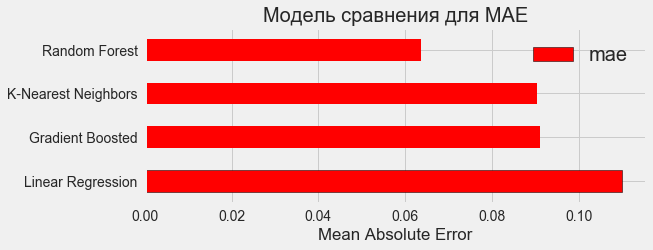

In [11]:
import matplotlib.pyplot as plt # рисовать графики
%matplotlib inline
# Set default font size
plt.rcParams['font.size'] = 24
# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

from IPython.core.pylabtools import figsize
plt.style.use('fivethirtyeight')
figsize(8, 3)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Random Forest', 'Gradient Boosted', 'K-Nearest Neighbors'],
                                'mae': [lr_mae, random_forest_mae, gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh', 
                                                            color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Модель сравнения для MAE', size = 20);

Таким образом все эти оптимизации позволили улучшить первоначальную модель на 10%. На основании этих результатов выбираю модель смешанного дерева (Random Forest) и дальше работаю с ним.

Чтобы разобраться как работает модель, определяю какие признаки наиболее важные. Важности признаков позволяют увидеть связь каждого признака с целью прогнозирования. В приведённом ниже коде — обученная модель и с помощью графика feature_results определяю важности признаков. 

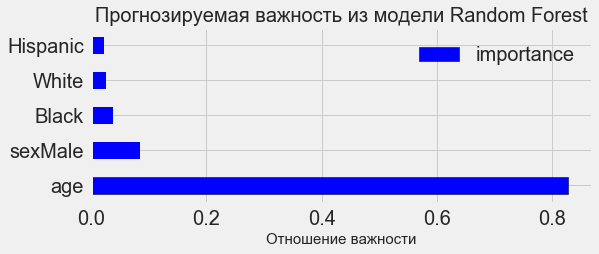

In [12]:
feature_results = pd.DataFrame({'feature': list(features.columns), 
                                'importance': random_forest.feature_importances_})
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

figsize(8, 3)
plt.style.use('fivethirtyeight')

# Показать важность признаков на графике
feature_results.loc[:5, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Отношение важности', size = 15); plt.ylabel('')
plt.title('Прогнозируемая важность из модели Random Forest', size = 20);

Как видно наибольшее влияние оказывает возраст. На основе этих результатов можно наконец-то ответить на один из основных вопросов: самыми важными признаками изменения относительной минеральной плотности позвоночника является признак возраста и пол.

Для того чтобы объяснить, как сформирован одиночный прогноз любой модели машинного обучения использую LIME (Локальные интерпретируемые моделезависимые объяснения). Создаю объясняющий объект (explainer) и передаю ему обучающие данные, информацию о режиме, метки для обучающих данных и имена признаков. Теперь можно передать explainer’у данные наблюдений и функцию прогнозирования, а потом попросить объяснить причину правдивости прогноза.

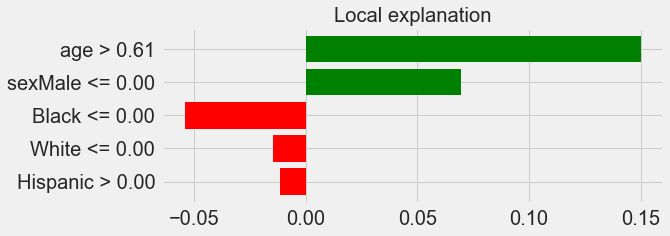

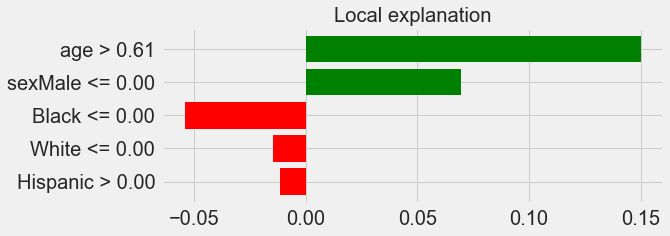

In [13]:
# LIME
import lime 
import lime.lime_tabular

# lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X, 
      mode = 'regression', training_labels = y, feature_names = list(features.columns))
exp = explainer.explain_instance(X_test[5,:], 
                                 random_forest.predict)
exp.as_pyplot_figure()

Интерпретирую диаграмму так, каждая запись по оси Y обозначает одно значение переменной, а красные и зелёные полосы отражают влияние этого значения на прогноз. Например, согласно верхней записи влияние age больше 0.61, в результате к прогнозу прибавляется 0.15 пунктов. Согласно второй записи влияние sexMale между 0:1, и поэтому к прогнозу прибавляется около 0.07 пунктов. Итоговый прогноз представляет собой сумму интерсепта и влияний каждого из перечисленных значений. Подобные инструменты могут сильно облегчить понимание работы модели и принимать более правильные решения.


# Выводы

Исспользуя возможности Python, я рассмотрела несколько этапов решения задачи машинного обучения:

1)Загрузка данных и корректировка

2)Взаимосвязь между моделями

3)Выбор признаков и LIME

Результаты свидетельствуют, что можно применять машинное обучение для прогнозирования изменения значений относительной минеральной плотности позвоночника подростков на основе доступных данных. А также можно опираться на возраст для определения среднего значения относительной минеральной плотности позвоночника. Наилучшее значение показала модель Random Forest(смешанного леса), также удалось на тестовых данных добиться погрешности в пределах 6%. 